### Advanced Machine Learning

# Home Exercise #4

Assignment Due: 17/05/21 23:59

Jonathan Schler

In [11]:
student1Name="Alexander Kruglyak"
student1ID="323637736"


student2Name="Sofya Zubtsovsky"
student2ID="337839112"


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, LogisticRegressionCV, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize, StandardScaler


import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:f}'.format

The goal of this homework is to try to solve the problem of predicting wine quality from review texts and other properties of the wine. You can find the dataset here:https://www.kaggle.com/zynicide/wine-reviews

While you can find several kernels on kaggle already, I highly recommend you start your ownsolution from scratch. For this homework, only use wine from the United States (only 42% of data). Feel free to subsample the data for building your model.

## Task 1 Bag of Words and simple Features [50pts]

1.1 Create a baseline model for predicting wine quality using only non-text features.





In [2]:
def show_data_basic_information(df):
    print("Info\n")
    print(df.info())
    print("\n" + "*" * 10 + "\n")
    
    print("Shape\n")
    print(df.shape) 
    print("\n" + "*" * 10 + "\n")
    
    print("Amount of is null data\n")
    print(df.isnull().sum().max())
    print("\n" + "*" * 10 + "\n")
    
    print("Describe\n")
    display(df.describe())
    print("\n" + "*" * 10 + "\n")

In [3]:
full_df = pd.read_csv("winemag-data-130k-v2.csv")

In [4]:
show_data_basic_information(full_df)

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), objec

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000



**********



In [5]:
full_df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,nan,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
def take_us_wines(_df):
    df = _df[_df['country']=="US"]
    return df

In [7]:
us_df = take_us_wines(full_df)
show_data_basic_information(us_df)

Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54504 entries, 2 to 129967
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             54504 non-null  int64  
 1   country                54504 non-null  object 
 2   description            54504 non-null  object 
 3   designation            36908 non-null  object 
 4   points                 54504 non-null  int64  
 5   price                  54265 non-null  float64
 6   province               54504 non-null  object 
 7   region_1               54226 non-null  object 
 8   region_2               50511 non-null  object 
 9   taster_name            37730 non-null  object 
 10  taster_twitter_handle  34741 non-null  object 
 11  title                  54504 non-null  object 
 12  variety                54504 non-null  object 
 13  winery                 54504 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usag

,Unnamed: 0,points,price
count,54504.000000,54504.000000,54265.000000
mean,65467.828563,88.563720,36.573464
std,37572.539161,3.114840,27.088857
min,2.000000,80.000000,4.000000
25%,33067.750000,86.000000,20.000000
50%,65678.500000,88.000000,30.000000
75%,98191.250000,91.000000,45.000000
max,129967.000000,100.000000,2013.000000



**********



In [8]:
def drop_nan_price(_df):
    df = _df.dropna(subset=['price'])
    return df

In [12]:
print('nan price before: ' + str(us_df['price'].isna().sum()))
us_df_cleaned = drop_nan_price(us_df)
print('nan price after: ' + str(us_df_cleaned['price'].isna().sum()))

nan price before: 239
nan price after: 0


In [13]:
def get_categorical_features(df):
    return df.select_dtypes(include=['object'])
def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])

In [14]:
def fill_nan_object_column(_df):
    df = _df.copy()
    categorical = get_categorical_features(_df)
    df[categorical.columns] = _df[categorical.columns].fillna("unknown")
    return df

In [15]:
print ('='*10 + " US wines as is\n"+'='*10,us_df_cleaned.isna().sum())
us_df_filled = fill_nan_object_column(us_df_cleaned)
print ('='*10 + " US wines without NaN\n"+'='*10,us_df_filled.isna().sum())

========== US wines as is
========== Unnamed: 0                   0
country                      0
description                  0
designation              17514
points                       0
price                        0
province                     0
region_1                   276
region_2                  3973
taster_name              16754
taster_twitter_handle    19730
title                        0
variety                      0
winery                       0
dtype: int64
========== US wines without NaN
========== Unnamed: 0               0
country                  0
description              0
designation              0
points                   0
price                    0
province                 0
region_1                 0
region_2                 0
taster_name              0
taster_twitter_handle    0
title                    0
variety                  0
winery                   0
dtype: int64


In [16]:
def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)

def get_label_and_drop(_df):
    df = _df.copy()
    label = df['points']
    df = drop_columns(df,['points'])
    return df, label

In [20]:
irrelevant_columns = ['Unnamed: 0','taster_name','taster_twitter_handle','country']
us_df_filled = drop_columns(us_df_filled,irrelevant_columns)

KeyError: "['Unnamed: 0' 'taster_name' 'taster_twitter_handle' 'country'] not found in axis"

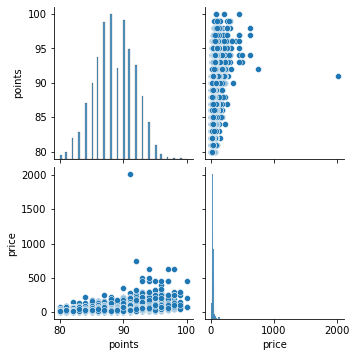

In [21]:
sns.pairplot(us_df_filled)

<AxesSubplot:xlabel='price', ylabel='Density'>

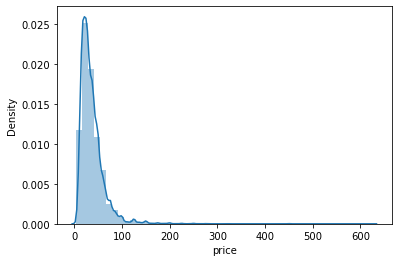

In [24]:
### remove anomally high price
us_df_filled = us_df_filled[us_df_filled.price != np.max(us_df_filled.price)]
us_df_filled
sns.distplot(us_df_filled['price'])


In [25]:
us_df_filled.sort_values(by='price',inplace=True)
us_df_filled.tail(10)

,description,designation,points,price,province,region_1,region_2,title,variety,winery
103128,Right now this is not typically soft and lush ...,La Joie,94,450.000000,California,Sonoma County,Sonoma,Verité 2008 La Joie Red (Sonoma County),Bordeaux-style Red Blend,Verité
128991,A pinch of hard tannins gives this bone-dry yo...,La Muse,93,450.000000,California,Sonoma County,Sonoma,Verité 2008 La Muse Red (Sonoma County),Bordeaux-style Red Blend,Verité
118066,"The blend is mainly Cabernet Sauvignon, with t...",La Joie,96,450.000000,California,Sonoma County,Sonoma,Verité 2007 La Joie Red (Sonoma County),Bordeaux-style Red Blend,Verité
118063,A spectacular wine that defines the upper limi...,Le Desir,97,450.000000,California,Sonoma County,Sonoma,Verité 2007 Le Desir Red (Sonoma County),Bordeaux-style Red Blend,Verité
118062,The 2008 vintage presented challenges for Cabe...,Le Desir,97,450.000000,California,Sonoma County,Sonoma,Verité 2008 Le Desir Red (Sonoma County),Bordeaux-style Red Blend,Verité
124436,"Here's a big, flashy, cult-style wine if ever ...",unknown,94,500.000000,California,Napa Valley,Napa,Harlan Estate 2006 Red (Napa Valley),Bordeaux-style Red Blend,Harlan Estate
15135,This is a hugely structured and concentrated w...,Double Plus Estate Grown,93,500.000000,California,Rutherford,Napa,Hewitt 2013 Double Plus Estate Grown Cabernet ...,Cabernet Sauvignon,Hewitt
38978,We can debate the pricing on Yao Ming's new re...,Family Reserve,98,625.000000,California,Napa Valley,Napa,Yao Ming 2010 Family Reserve Cabernet Sauvigno...,Cabernet Sauvignon,Yao Ming
25382,"As imposing as the athlete himself, this is an...",Family Reserve,94,625.000000,California,Napa Valley,Napa,Yao Ming 2011 Family Reserve Cabernet Sauvigno...,Cabernet Sauvignon,Yao Ming
83852,The former basketball star's initial release i...,Family Reserve,97,625.000000,California,Napa Valley,Napa,Yao Ming 2009 Family Reserve Cabernet Sauvigno...,Cabernet Sauvignon,Yao Ming


Text(0.5, 1.0, 'Distribution of points')

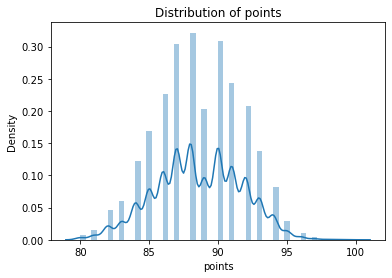

In [26]:
sns.distplot(us_df_filled['points'], hist=True, kde=True)
plt.title("Distribution of points")

In [27]:
def print_unique_count(df):
    for (featureName, featureData) in df.select_dtypes(include=['object']).iteritems():
        print("{} has unique values: {}".format(featureName, featureData.nunique()))

In [28]:
def show_random_text(_df,feature,n=1):
    df = _df.sample(n=n,random_state=42)
    print(list(df[feature]))

In [29]:
show_random_text(us_df_filled,'description')

['The nose on this blend of Merlot, Syrah, Cabernet Franc and Cabernet Sauvignon is a bit tight, with subtle notes of cocoa powder, raspberry and angel food cake. On the palate, fine tannins give structure, but the flavors taste equally muted.']


In [30]:
show_random_text(us_df_filled,'designation',5)

['Winemakers Select Bin 11', 'Reserve', 'Mormann Vineyard', 'unknown', 'StevensDivio']


In [31]:
show_random_text(us_df_filled,'title',10)

['Tarara 2012 Winemakers Select Bin 11 Red (Virginia)', 'Rock View 2013 Reserve Chardonnay (Mendocino)', 'Lea 2015 Mormann Vineyard Chardonnay (Santa Barbara County)', 'Summerland 2014 Pinot Noir (Santa Barbara County)', 'Stevens 2013 StevensDivio Viognier (Yakima Valley)', 'Schug 2010 Heritage Reserve Chardonnay (Carneros)', 'Sagelands 2004 Four Corners Cabernet Sauvignon (Columbia Valley (WA))', 'Ruby Hill Winery 2012 Jewel Collection Series Estate Reserve Cabernet Sauvignon (Livermore Valley)', 'JM Cellars 2011 Tre Red (Columbia Valley (WA))', 'Amor Fati 2014 Murmur Vineyard Syrah (Santa Maria Valley)']


In [32]:
show_random_text(us_df_filled,'variety',10)

['Red Blend', 'Chardonnay', 'Chardonnay', 'Pinot Noir', 'Viognier', 'Chardonnay', 'Cabernet Sauvignon', 'Cabernet Sauvignon', 'Red Blend', 'Syrah']


In [33]:
show_random_text(us_df_filled,'winery',10)

['Tarara', 'Rock View', 'Lea', 'Summerland', 'Stevens', 'Schug', 'Sagelands', 'Ruby Hill Winery', 'JM Cellars', 'Amor Fati']


In [34]:
show_random_text(us_df_filled,'region_1',10)

['Virginia', 'Mendocino', 'Santa Barbara County', 'Santa Barbara County', 'Yakima Valley', 'Carneros', 'Columbia Valley (WA)', 'Livermore Valley', 'Columbia Valley (WA)', 'Santa Maria Valley']


In [35]:
show_random_text(us_df_filled,'region_2',10)

['unknown', 'unknown', 'Central Coast', 'Central Coast', 'Columbia Valley', 'Napa-Sonoma', 'Columbia Valley', 'Central Coast', 'Columbia Valley', 'Central Coast']


In [36]:
print_unique_count(us_df_filled)

description has unique values: 50228
designation has unique values: 14131
province has unique values: 27
region_1 has unique values: 265
region_2 has unique values: 18
title has unique values: 50010
variety has unique values: 257
winery has unique values: 5368


In [37]:
us_df_filled.winery.value_counts().head(20)

Testarossa               217
Williams Selyem          211
Chateau Ste. Michelle    193
Columbia Crest           158
Kendall-Jackson          130
Siduri                   126
Gary Farrell             125
Lynmar                   118
Robert Mondavi           112
Fess Parker              108
V. Sattui                107
Iron Horse               106
Foxen                    105
Chehalem                 102
Maryhill                 102
Kunde                    101
Dutton-Goldfield         100
Terre Rouge              100
Martin Ray                98
Kenwood                   98
Name: winery, dtype: int64

In [38]:
def get_dummies(_df,columns_to_dummy):
    df = _df.copy()
    df = pd.get_dummies(df,columns=columns_to_dummy)
    return df

In [39]:
def get_cat_codes(_df,columns_to_cat):
    df = _df.copy()
    for col in columns_to_cat:
        df[col]= df[col].astype('category').cat.codes
    return df

In [40]:
# columns_to_dummy = ['province','variety']
columns_to_dummy = ['province','variety','region_1']
# columns_to_codes = ['region_1','region_2','winery','title']

In [260]:
for col in columns_to_dummy:
    print('==='+col+'===')
    print(us_df_filled[col].value_counts())

===province===
California        36103
Washington         8583
Oregon             5359
New York           2676
Virginia            770
Idaho               190
Michigan            111
America              95
Texas                93
Colorado             68
other                57
New Mexico           45
Arizona              40
Missouri             33
North Carolina       23
Pennsylvania         18
Name: province, dtype: int64
===variety===
Pinot Noir                  9857
other                       9161
Cabernet Sauvignon          7280
Chardonnay                  6772
Syrah                       3232
Red Blend                   2948
Zinfandel                   2705
Merlot                      2300
Sauvignon Blanc             2154
Bordeaux-style Red Blend    1817
Riesling                    1745
Cabernet Franc               999
Rosé                         900
Pinot Gris                   863
Viognier                     786
Petite Sirah                 745
Name: variety, dtype: int64
==

In [261]:
def cat_feature_to_other(df, featureName):
    _df = df.copy()
    total = len(_df[featureName].value_counts().index.to_list())
    to_default = total - 15
    less_popular = _df[featureName].value_counts().tail(to_default).index.tolist()
    _df[featureName].replace(to_replace=less_popular, value='other', inplace=True)
    return _df

In [262]:
for col in columns_to_dummy:
    us_df_filled = cat_feature_to_other(us_df_filled,col)

In [263]:
for col in columns_to_dummy:
    print('==='+col+'===')
    print(us_df_filled[col].value_counts())

===province===
California        36103
Washington         8583
Oregon             5359
New York           2676
Virginia            770
Idaho               190
Michigan            111
America              95
Texas                93
other                75
Colorado             68
New Mexico           45
Arizona              40
Missouri             33
North Carolina       23
Name: province, dtype: int64
===variety===
other                       9906
Pinot Noir                  9857
Cabernet Sauvignon          7280
Chardonnay                  6772
Syrah                       3232
Red Blend                   2948
Zinfandel                   2705
Merlot                      2300
Sauvignon Blanc             2154
Bordeaux-style Red Blend    1817
Riesling                    1745
Cabernet Franc               999
Rosé                         900
Pinot Gris                   863
Viognier                     786
Name: variety, dtype: int64
===region_1===
other                      26063
Napa Valley

In [264]:
us_dummied = get_dummies(us_df_filled,columns_to_dummy)

In [265]:
columns_to_drop = ['description','designation','title','winery','region_2']
us_df_cleaned = drop_columns(us_dummied,columns_to_drop)

In [266]:
show_data_basic_information(us_df_cleaned)

Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54264 entries, 64590 to 51978
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   points                            54264 non-null  int64  
 1   price                             54264 non-null  float64
 2   province_America                  54264 non-null  uint8  
 3   province_Arizona                  54264 non-null  uint8  
 4   province_California               54264 non-null  uint8  
 5   province_Colorado                 54264 non-null  uint8  
 6   province_Idaho                    54264 non-null  uint8  
 7   province_Michigan                 54264 non-null  uint8  
 8   province_Missouri                 54264 non-null  uint8  
 9   province_New Mexico               54264 non-null  uint8  
 10  province_New York                 54264 non-null  uint8  
 11  province_North Carolina           54264 non-null  uint8  

,points,price,province_America,province_Arizona,province_California,province_Colorado,province_Idaho,province_Michigan,province_Missouri,province_New Mexico,...,region_1_Paso Robles,region_1_Russian River Valley,region_1_Santa Barbara County,region_1_Sonoma Coast,region_1_Sonoma County,region_1_Sta. Rita Hills,region_1_Walla Walla Valley (WA),region_1_Willamette Valley,region_1_Yakima Valley,region_1_other
count,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,...,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000
mean,88.566342,36.537041,0.001751,0.000737,0.665321,0.001253,0.003501,0.002046,0.000608,0.000829,...,0.042883,0.056944,0.018318,0.027034,0.022943,0.017894,0.019553,0.042312,0.018134,0.480300
std,3.116837,25.726073,0.041805,0.027141,0.471882,0.035378,0.059069,0.045182,0.024653,0.028786,...,0.202595,0.231737,0.134099,0.162185,0.149724,0.132567,0.138458,0.201301,0.133436,0.499616
min,80.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,86.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,88.000000,30.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,91.000000,45.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,100.000000,750.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



**********



## Linear models on numerical data

In [267]:
def add_score(scores_df, score, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'r2'] = np.mean(score)

In [268]:
def get_cross_val_score(scores_df,estimator,X_train,y_train,prefix="",sampler=None):
        name = estimator.__class__.__name__
        pipe = estimator
        sampler_name = ""
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        score = cross_val_score(
            pipe,
            X_train, 
            y_train, 
            cv=10,
            scoring=('r2'),
            n_jobs = -1
        )
        add_score(scores_df, score, estimator.__class__.__name__,prefix)

In [269]:
rergressors = [LinearRegression(),Ridge(),Lasso(),ElasticNet()] 
scores_df = pd.DataFrame(dtype=float)

In [270]:
def scale_columns(_df,columns):
    df = _df.copy()
    st_sclr = StandardScaler()
    df[columns] = st_sclr.fit_transform(df[columns])
    return df

In [ ]:
columns_to_scale = ['price']
us_scaled_price = scale_columns(us_dummied,columns_to_scale)
sns.pairplot(us_scaled_price)

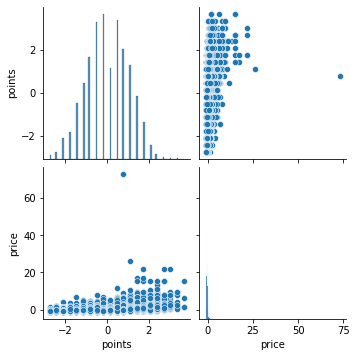

In [153]:
columns_to_scale = ['price','points']
us_scaled_price_points = scale_columns(us_df_filled,columns_to_scale)
sns.pairplot(us_scaled_price_points)

In [271]:
X_num = get_continuous_features(us_df_cleaned)
X,y = get_label_and_drop(X_num)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)
X_train.describe()

,price,province_America,province_Arizona,province_California,province_Colorado,province_Idaho,province_Michigan,province_Missouri,province_New Mexico,province_New York,...,region_1_Paso Robles,region_1_Russian River Valley,region_1_Santa Barbara County,region_1_Sonoma Coast,region_1_Sonoma County,region_1_Sta. Rita Hills,region_1_Walla Walla Valley (WA),region_1_Willamette Valley,region_1_Yakima Valley,region_1_other
count,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,...,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000
mean,36.422920,0.001843,0.000811,0.665291,0.001081,0.003342,0.001769,0.000565,0.000811,0.049093,...,0.042140,0.056366,0.018723,0.027274,0.022851,0.017790,0.019559,0.043098,0.017740,0.481326
std,25.207302,0.042889,0.028464,0.471895,0.032863,0.057711,0.042024,0.023766,0.028464,0.216066,...,0.200910,0.230631,0.135548,0.162883,0.149431,0.132187,0.138480,0.203080,0.132008,0.499657
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,625.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [273]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"numerical")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.297411
Ridge_numerical,0.297416
Lasso_numerical,0.230605
ElasticNet_numerical,0.230707


In [274]:
def get_year_from_title(x):
    arr = x['title'].split()
    arr = [int(s) for s in arr if s.isdigit() and int(s) > 1800 and int(s) <= 2021]
    if len(arr) >= 1:
        return arr[0]
    return -1
us_df_filled["Wine_Year"] = us_df_filled.apply(get_year_from_title, axis=1)

In [275]:
us_df_filled

,description,designation,points,price,province,region_1,region_2,title,variety,winery,Wine_Year
64590,"There's a lot going on in this Merlot, which i...",unknown,86,4.000000,California,California,California Other,Bandit NV Merlot (California),Merlot,Bandit,-1
59507,"Sweet and fruity, this canned wine feels soft ...",Unoaked,83,4.000000,California,California,California Other,Pam's Cuties NV Unoaked Chardonnay (California),Chardonnay,Pam's Cuties,-1
31530,"Packaged in a cute yellow recyclable Tetrapak,...",unknown,84,4.000000,California,California,California Other,Bandit NV Chardonnay (California),Chardonnay,Bandit,-1
110255,"A good everyday Merlot, dry and rich in tannin...",unknown,84,4.000000,California,California,California Other,Bandit NV Merlot (California),Merlot,Bandit,-1
20484,"Fruity, soft and rather sweet, this wine smell...",unknown,85,4.000000,California,other,Central Valley,Dancing Coyote 2015 White (Clarksburg),other,Dancing Coyote,2015
...,...,...,...,...,...,...,...,...,...,...,...
15135,This is a hugely structured and concentrated w...,Double Plus Estate Grown,93,500.000000,California,other,Napa,Hewitt 2013 Double Plus Estate Grown Cabernet ...,Cabernet Sauvignon,Hewitt,2013
25382,"As imposing as the athlete himself, this is an...",Family Reserve,94,625.000000,California,Napa Valley,Napa,Yao Ming 2011 Family Reserve Cabernet Sauvigno...,Cabernet Sauvignon,Yao Ming,2011
38978,We can debate the pricing on Yao Ming's new re...,Family Reserve,98,625.000000,California,Napa Valley,Napa,Yao Ming 2010 Family Reserve Cabernet Sauvigno...,Cabernet Sauvignon,Yao Ming,2010
83852,The former basketball star's initial release i...,Family Reserve,97,625.000000,California,Napa Valley,Napa,Yao Ming 2009 Family Reserve Cabernet Sauvigno...,Cabernet Sauvignon,Yao Ming,2009


In [ ]:
X_num = get_continuous_features(us_df_cleaned)
X,y = get_label_and_drop(X_num)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)

for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"_add_year")

scores_df

1.2 Create a simple text-based model using a bag-of-words approach and a linear model.


In [85]:
us_df_filled['description'] = us_df_filled['description'].replace(b"<br />", b" ")

In [87]:
text_trainval = us_df_filled['description'].tolist()
y_trainval = us_df_filled['points']
print("type of text_train: ", type(text_trainval))
print("length of text_train: ", len(text_trainval))
print("class balance: ", np.bincount(y_trainval))

type of text_train:  <class 'list'>
length of text_train:  54265
class balance:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  157  326 1006 1304
 2667 3667 4904 6599 6978 4395 6684 5284 4505 3005 1793  640  221   81
   33   12    4]


In [88]:
text_trainval

['Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.',
 'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.',
 "Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",
 'Soft, supple plum envelopes an oaky structure in this Cabernet, supported by 15% Merlot. Coffee and chocolate complete the picture, finishing strong at the end, resulting in a value-priced wine of attractive flavor and immediate accessibility.',
 'Slightly reduced, this wine offers a chalky, tannic backbone to an otherwise juicy explosion of rich 

In [89]:
text_train, text_val, y_train, y_val = train_test_split(text_trainval, y_trainval, stratify=y_trainval,random_state=0)

In [90]:
vect = CountVectorizer(stop_words='english',min_df=4)
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)
X_train

<40698x8146 sparse matrix of type '<class 'numpy.int64'>'
	with 959664 stored elements in Compressed Sparse Row format>

In [91]:
print(X_train.shape, y_train.shape)

(40698, 8146) (40698,)


In [92]:
#Vocabulary
feature_names = vect.get_feature_names()
print(feature_names[:10])
print(feature_names[20000:20020])
print(feature_names[::2000])

['000', '02', '03', '04', '05', '06', '07', '08', '09', '10']
[]
['000', 'deficient', 'larner', 'riverbench', 'wilson']


In [93]:
lr = LogisticRegression(n_jobs=-1).fit(X_train, y_train)
lr.score(X_val,y_val)

0.2562099211321589

1.3 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. Be aware that you might need to adjust the (regularization of the) linear model for different feature sets.


In [ ]:
#your code here

In [85]:
#TfidfVectorizer
tdif = TfidfVectorizer(stop_words='english',min_df=4)
X_train = tdif.fit_transform(text_train)
X_val = tdif.transform(text_val)

In [86]:
lr = LogisticRegression(n_jobs=-1).fit(X_train, y_train)
lr.score(X_val,y_val)

0.08881845654897914

In [87]:
# L1 normalization with CountVectorizer
count_vec = CountVectorizer(stop_words='english',min_df=4)
X_train = count_vec.fit_transform(text_train)
X_train = normalize(X_train,norm="l1")
X_val = count_vec.transform(text_val)

In [88]:
lr = LogisticRegression(n_jobs=-1).fit(X_train, y_train)
lr.score(X_val,y_val)

0.0507112847350188

In [ ]:
#ngrams
ngrm = CountVectorizer(ngram_range=(1, 3), min_df=4,stop_words='english')
X_train = ngrm.fit_transform(text_train)
lr = LogisticRegressionCV().fit(X_train, y_train)
lr.score(X_val, y_val)

1.4 Combine the non-text features and the text features. How does adding those features improve upon just using bag-of-words?

In [ ]:
#your code here

## Task 2 Word Vectors [50pts]

Use a pretrained word-embedding (word2vec, glove or fasttext) for featurization instead of the bag-of-words model. Does this improve classification? How about combining the embedded words with the BoW model?

In [1]:
#your code here

# Task 3 Transformers (bonus / optional) [50pts] - Like Extra Assignment with 50% weight

Fine-tune a BERT model on the text data alone using the transformers library. How does this model compare to a BoW model, and how does it compare to a model using all features?

In [2]:
#your code here